# IMDB电影评论分类

In [1]:
from keras import models
from keras import layers

## 加载数据集

In [8]:
from keras.datasets import imdb

NUM_WORDS = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(25000,) (25000,) (25000,) (25000,)


In [11]:
print(x_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


## 数据向量化

In [12]:
import numpy as np

def vectorize_words(words):
    x = np.zeros((words.shape[0], NUM_WORDS))
    for i, word_indexs in enumerate(words):
        x[i, word_indexs] = 1.0
    
    return x

In [85]:
xtrain = vectorize_words(x_train)
xtest = vectorize_words(x_test)

ytrain = y_train.astype(np.float32)
ytest = y_test.astype(np.float32)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(25000,) (25000,) (25000,) (25000,)
(25000, 10000) (25000,) (25000, 10000) (25000,)


## 留出验证集

In [16]:
NUM_VALIDATION = 10000

xtrain_subset = xtrain[NUM_VALIDATION:]
xval = xtrain[:NUM_VALIDATION]

ytrain_subset = ytrain[NUM_VALIDATION:]
yval = ytrain[:NUM_VALIDATION]

## 构建网络模型

In [24]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [49]:
model = build_model()
history20 = model.fit(xtrain_subset, ytrain_subset, epochs=20, batch_size=512,　
                      validation_data=(xval, yval), verbose=0)
model.evaluate(xtest, ytest)

25000/25000 [==============================] - 2s 68us/step


[0.856730600540638, 0.83876]

## 绘制损失率和准确率

In [56]:
import matplotlib.pyplot as plt

def draw(history):
    hist = history.history
    val_loss = hist['val_loss']
    val_acc = hist['val_acc']
    loss = hist['loss']
    acc = hist['acc']

    epochs = range(1, len(val_loss)+1)

    plt.figure(figsize=(20, 6))

    plt.subplot(121)
    plt.plot(epochs, loss, 'bo', label='Train loss')
    plt.plot(epochs, val_loss, 'r+', label='Validation loss')
    plt.title('Train and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, acc, 'bo', label='Train accuracy')
    plt.plot(epochs, val_acc, 'r+', label='Validation accuracy')
    plt.title('Train and Validation accuracy')
    plt.xlabel('Train accuracy')
    plt.ylabel('Validation accuracy')
    plt.legend()

    plt.show()

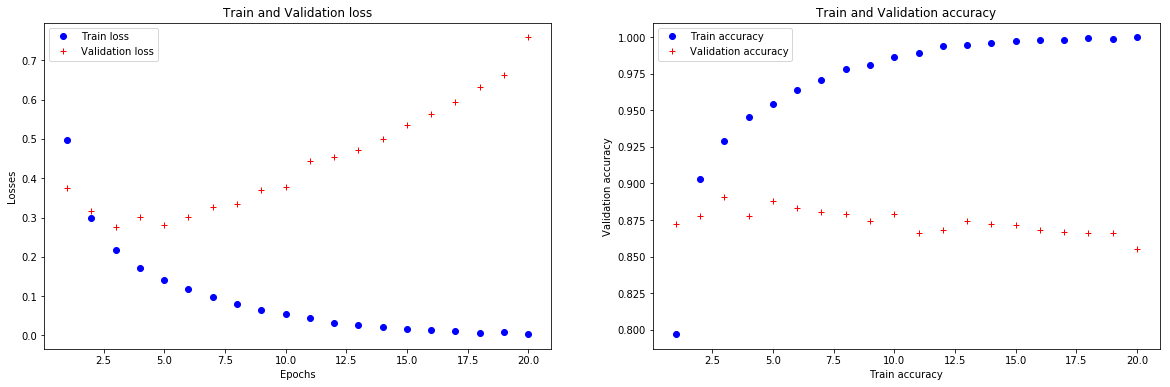

In [50]:
draw(history20)

25000/25000 [==============================] - 1s 57us/step
[0.30080809470176695, 0.87912]


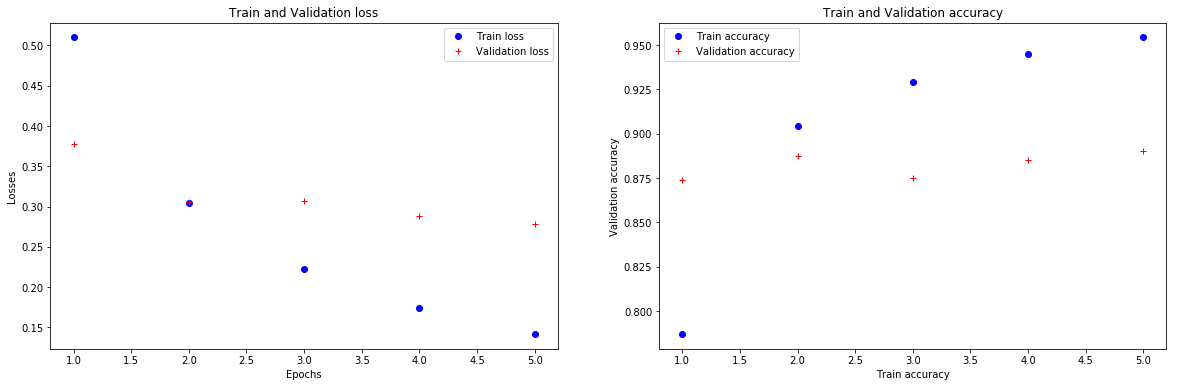

In [51]:
# 通过观察上图，发现epochs在5达到了最好。

model = build_model()
history5 = model.fit(xtrain_subset, ytrain_subset, epochs=5, batch_size=512, 
                     validation_data=(xval, yval), verbose=0)
print(model.evaluate(xtest, ytest))
draw(history5)

## K折验证

In [103]:
K = 4
num = x_train.shape[0] // K
val_accs = []
for k in range(K):
    xval = xtrain[k*num:(k+1)*num]
    yval = ytrain[k*num:(k+1)*num]
    xtrain_subset = np.concatenate([xtrain[:k*num], xtrain[(k+1)*num:]], axis=0)
    ytrain_subset = np.concatenate([ytrain[:k*num], ytrain[(k+1)*num:]], axis=0)
    
    model = build_model()
    history = model.fit(xtrain_subset, ytrain_subset, epochs=20, batch_size=512, 
                        validation_data=(xval, yval), verbose=0)
    val_accs.append(history.history['val_acc'])

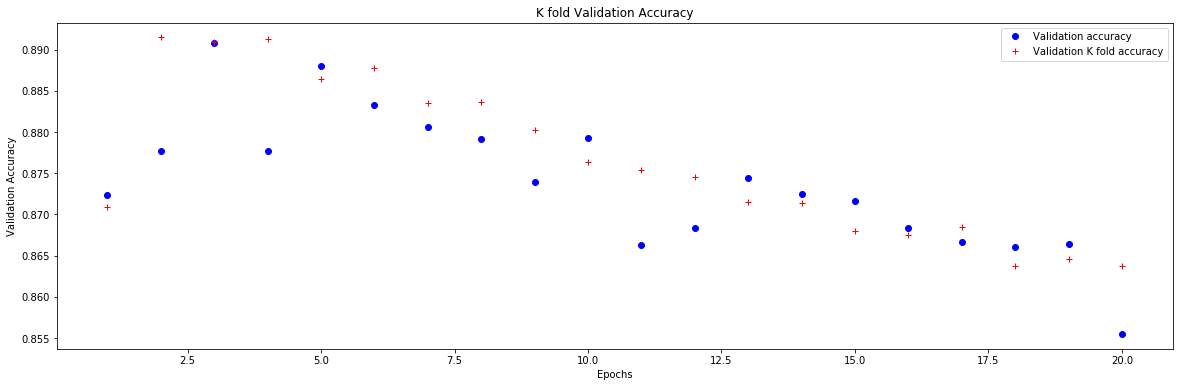

In [104]:
val_acc_k = [np.average(np.array(val_accs)[:, i]) for i in range(len(val_accs[0]))]
val_acc = history20.history['val_acc']

epochs = range(1, len(val_acc)+1)

plt.figure(figsize=(20, 6))
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.plot(epochs, val_acc_k, 'r+', label='Validation K fold accuracy')
plt.title('K fold Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.show()

## 重复K折

In [100]:
val_accs_k = []
for i in range(4):
    K = 4
    num = x_train.shape[0] // K
    val_accs = []
    for k in range(K):
        xval = xtrain[k*num:(k+1)*num]
        yval = ytrain[k*num:(k+1)*num]
        xtrain_subset = np.concatenate([xtrain[:k*num], xtrain[(k+1)*num:]], axis=0)
        ytrain_subset = np.concatenate([ytrain[:k*num], ytrain[(k+1)*num:]], axis=0)

        model = build_model()
        history = model.fit(xtrain_subset, ytrain_subset, epochs=20, batch_size=512, 
                            validation_data=(xval, yval), verbose=0)
        val_accs.append(history.history['val_acc'])
        
    val_acc_k = [np.average(np.array(val_accs)[:, i]) for i in range(len(val_accs[0]))]
    val_accs_k.append(val_acc_k)

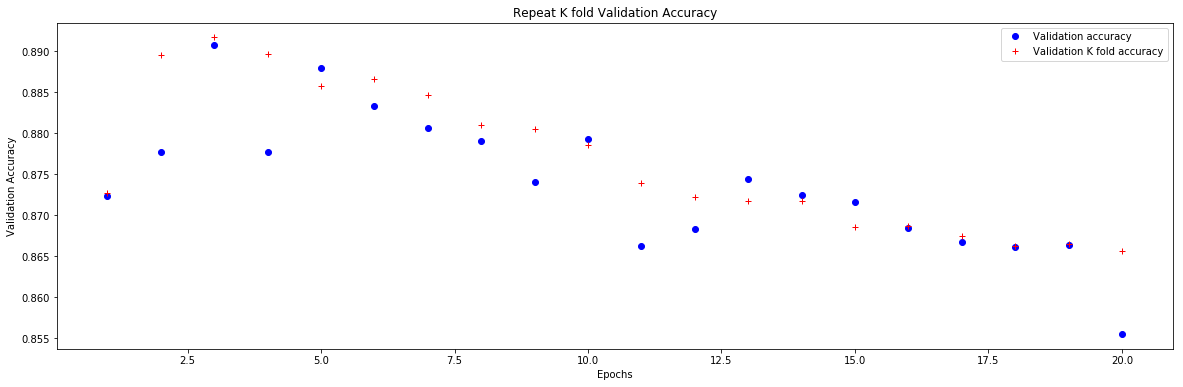

In [101]:
val_acc_k = [np.average(np.array(val_accs_k)[:, i]) for i in range(len(val_accs_k[0]))]
val_acc = history20.history['val_acc']

epochs = range(1, len(val_acc)+1)

plt.figure(figsize=(20, 6))
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.plot(epochs, val_acc_k, 'r+', label='Validation K fold accuracy')
plt.title('Repeat K fold Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.show()

**花了老长时间跑完了，没有效果。**

## 小模型

25000/25000 [==============================] - 2s 69us/step
[0.3606483652496338, 0.86856]


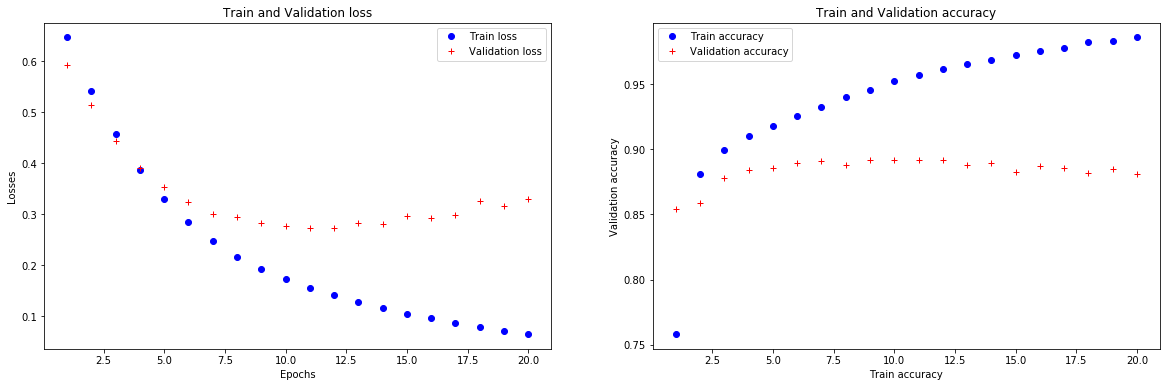

In [59]:
def build_model_with_smaller():
    model = models.Sequential()
    model.add(layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model_with_smaller()
history_with_smaller20 = model.fit(xtrain_subset, ytrain_subset, epochs=20, batch_size=512, 
                                   validation_data=(xval, yval), verbose=0)
print(model.evaluate(xtest, ytest))
draw(history_with_smaller20)

## Dropout正则化

25000/25000 [==============================] - 1s 59us/step
[0.5593732934808731, 0.87196]


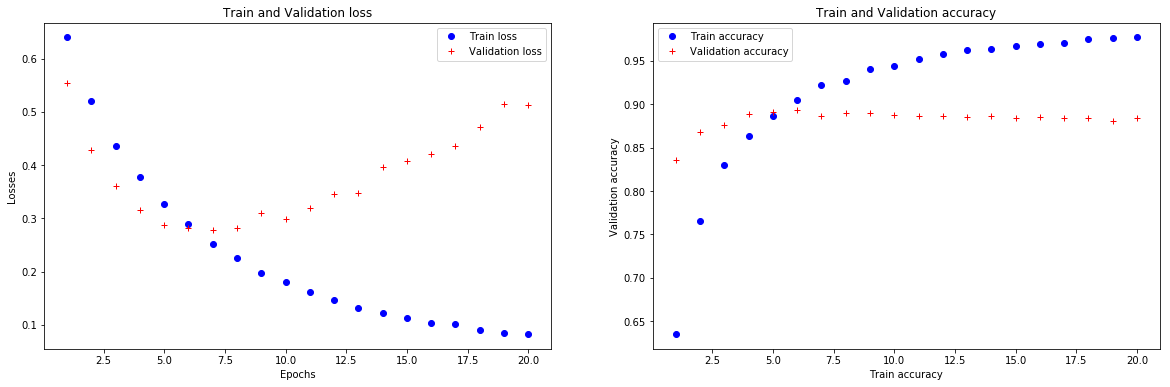

In [53]:
def build_model_with_dropout():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model_with_dropout()
history_with_dropout20 = model.fit(xtrain_subset, ytrain_subset, epochs=20, batch_size=512, 
                                   validation_data=(xval, yval), verbose=0)
print(model.evaluate(xtest, ytest))
draw(history_with_dropout20)

## 权重正则化

25000/25000 [==============================] - 2s 61us/step
[0.5263031043815612, 0.84868]


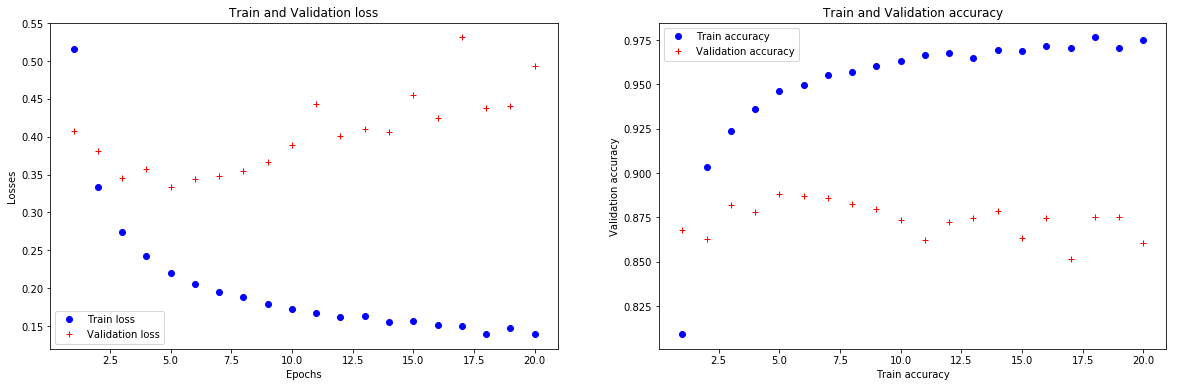

In [54]:
from keras import regularizers

def build_model_with_regularizers():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,), 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model_with_regularizers()
history_with_regularizers20 = model.fit(xtrain_subset, ytrain_subset, epochs=20, batch_size=512, 
                                        validation_data=(xval, yval), verbose=0)
print(model.evaluate(xtest, ytest))
draw(history_with_regularizers20)

## 不同的优化验证损失结果对比

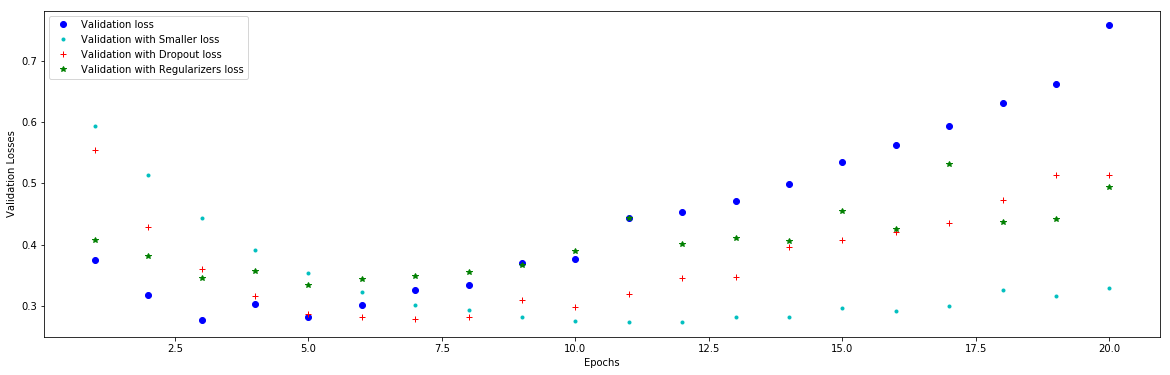

In [61]:
val_loss = history20.history['val_loss']
val_loss_with_smaller = history_with_smaller20.history['val_loss']
val_loss_with_dropout = history_with_dropout20.history['val_loss']
val_loss_with_regularizers = history_with_regularizers20.history['val_loss']

epochs = range(1, len(val_loss)+1)

plt.figure(figsize=(20, 6))
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, val_loss_with_smaller, 'c.', label='Validation with Smaller loss')
plt.plot(epochs, val_loss_with_dropout, 'r+', label='Validation with Dropout loss')
plt.plot(epochs, val_loss_with_regularizers, 'g*', label='Validation with Regularizers loss')

plt.xlabel('Epochs')
plt.ylabel('Validation Losses')
plt.legend()

plt.show()

## 小模型，正则化，Dropout的等的组合优化尝试

25000/25000 [==============================] - 2s 64us/step
[0.5313784303092957, 0.84716]


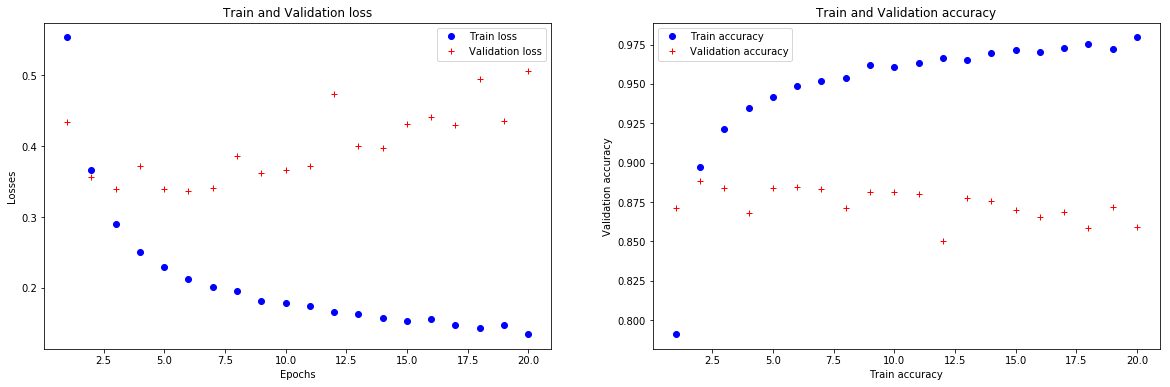

In [64]:
from keras import regularizers

def build_model_with_all():
    model = models.Sequential()
    model.add(layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,), 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model_with_regularizers()
history_all20 = model.fit(xtrain_subset, ytrain_subset, epochs=20, batch_size=512, 
                          validation_data=(xval, yval), verbose=0)
print(model.evaluate(xtest, ytest))
draw(history_all20)

25000/25000 [==============================] - 2s 62us/step
[0.4672146919441223, 0.86228]


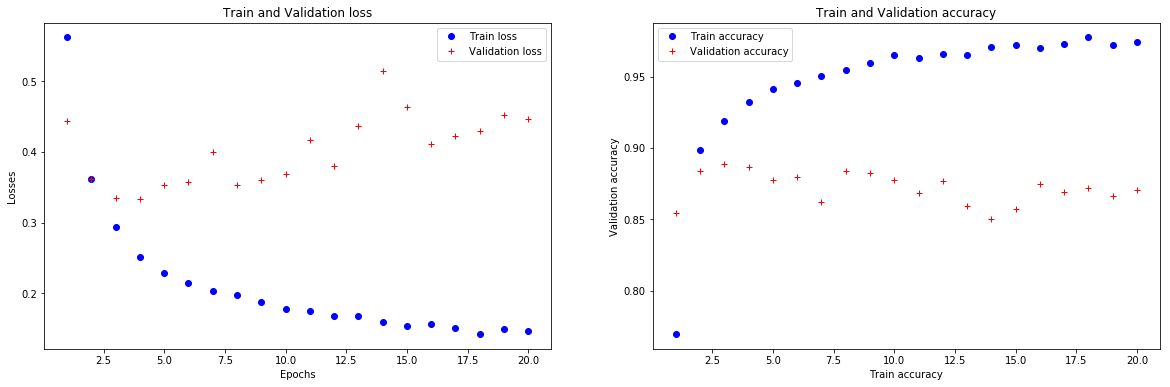

In [65]:
from keras import regularizers

def build_model_with_all():
    model = models.Sequential()
    model.add(layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,), 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model_with_regularizers()
history_all20 = model.fit(xtrain_subset, ytrain_subset, epochs=20, batch_size=512, 
                          validation_data=(xval, yval), verbose=0)
print(model.evaluate(xtest, ytest))
draw(history_all20)

25000/25000 [==============================] - 2s 65us/step
[0.4666121032333374, 0.8598]


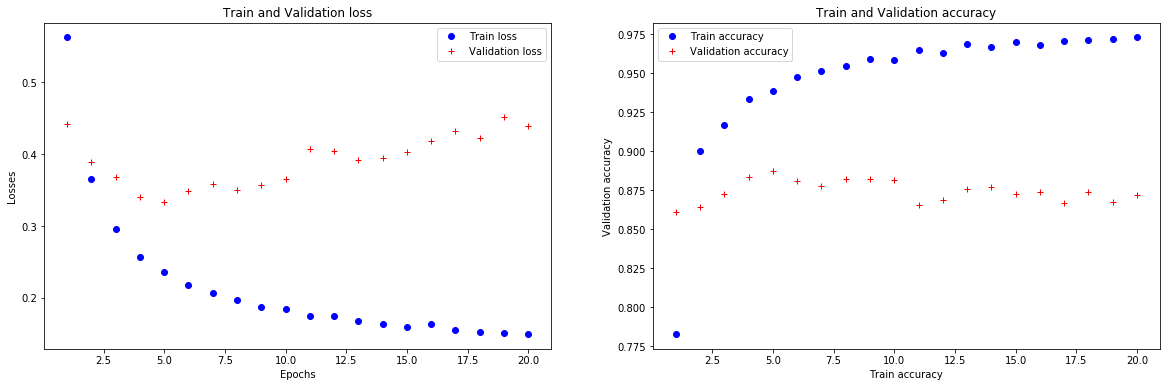

In [66]:
from keras import regularizers

def build_model_with_all():
    model = models.Sequential()
    model.add(layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model_with_regularizers()
history_all20 = model.fit(xtrain_subset, ytrain_subset, epochs=20, batch_size=512, 
                          validation_data=(xval, yval), verbose=0)
print(model.evaluate(xtest, ytest))
draw(history_all20)